
#Work 1 on Pegasus-large model: Generating Summaries with Pegasus Out-of-the-Box

The Harvard USPTO Dataset (HUPD) is a large-scale, well-structured, and multi-purpose corpus of English-language utility patent applications filed to the United States Patent and Trademark Office (USPTO) between January 2004 and December 2018. Sourced from [HuggingFace](https://huggingface.co/datasets/HUPD/hupd).

In this workbook we will explore the data and experiment with abstractive summarization using different sections as input ids.

## Setup

In [ ]:
#install libraries
!pip install -q datasets
!pip install -q transformers
!pip install --quiet --upgrade accelerate
!pip install -q sentencepiece
!pip install -q evaluate
!pip install -q rouge_score
!pip install tensorflow --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.6 MB/s eta 0:00:00


In [ ]:

# Install Packages

#standard data science libraries
import pandas as pd
import numpy as np
import random
import matplotlib

#visualization
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display, HTML

#datasets
import datasets
from datasets import load_dataset, load_metric
# transformers
# from transformers import AutoTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# PyTorch
import torch
from torch.utils.data import DataLoader

#rouge
import evaluate

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
##### ensure you mount to the folder that you want.
# from google.colab import drive
# drive.mount('/content/drive')

##Load Data

In [ ]:
#Load Dataset

dataset_dict = load_dataset('HUPD/hupd',
    name='sample',
    data_files="https://huggingface.co/datasets/HUPD/hupd/blob/main/hupd_metadata_2022-02-22.feather",
    ipcr_label='C07',
    #selecting only a small portion of the training data from Jan 2016
    train_filing_start_date='2016-01-01',
    train_filing_end_date='2016-01-31',
    #for the moment we won't work with validation data (extract 0)
    val_filing_start_date='2016-01-06',
    val_filing_end_date='2016-01-06',
)

print('Loading is done!')

Loading dataset with config: PatentsConfig(name='sample', version=0.0.0, data_dir='sample', data_files={'train': ['https://huggingface.co/datasets/HUPD/hupd/blob/main/hupd_metadata_2022-02-22.feather']}, description='Patent data from January 2016, for debugging')


Using metadata file: /root/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710


Reading metadata file: /root/.cache/huggingface/datasets/downloads/bac34b767c2799633010fa78ecd401d2eeffd62eff58abdb4db75829f8932710
Filtering by IPCR label: C07
Filtering train dataset by filing start date: 2016-01-01
Filtering train dataset by filing end date: 2016-01-31
Filtering val dataset by filing start date: 2016-01-06
Filtering val dataset by filing end date: 2016-01-06


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Loading is done!


From HF: If you do not want to extract the entire dataset at once but rather extract the years that you are interested in, please make sure to set the force_extract parameter to be True. When this parameter is True, you download the files that appear only in the years of our interest; hence, you might save a lot of disk space.

## Explore HUPD Dataset

In [ ]:
#Review the structure of the dataset
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
        num_rows: 720
    })
    validation: Dataset({
        features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
        num_rows: 0
    })
})


In [ ]:
# Print info about the sizes of the train and validation sets
print(f'Train dataset size: {dataset_dict["train"].shape}')

Train dataset size: (720, 14)


In [ ]:
#prepare training and validation sets
train_set = dataset_dict['train']

We review the data to make some initial observations:



In [ ]:
for i in range(1,50):
  abstract = train_set[i]['abstract']
  background = train_set[i]['background']
  summary = train_set[i]['summary']
  description = train_set[i]['description']
  claims = train_set[i]['claims']
  pprint(f'#{i} Len abstract: {len(abstract.split())}')
  pprint(f'#{i} Len background: {len(background.split())}')
  pprint(f'#{i} Len summary: {len(summary.split())}')
  pprint(f'#{i} Len description: {len(description.split())}')
  pprint(f'#{i} Len claims: {len(claims.split())}')
  pprint('_'*100)
  # pprint(f'#{i} Example abstract: {abstract}')
  # pprint(f'#{i} Example background: {background}')
  # pprint(f'#{i} Example summary: {summary}')
  # pprint(f'#{i} Example description: {description}')
  # pprint(f'#{i} Example claims: {claims}')
  # pprint('_'*100)

'#1 Len abstract: 228'
'#1 Len background: 290'
'#1 Len summary: 6'
'#1 Len description: 10275'
'#1 Len claims: 781'
'____________________________________________________________________________________________________'
'#2 Len abstract: 92'
'#2 Len background: 19'
'#2 Len summary: 54'
'#2 Len description: 2895'
'#2 Len claims: 187'
'____________________________________________________________________________________________________'
'#3 Len abstract: 38'
'#3 Len background: 760'
'#3 Len summary: 311'
'#3 Len description: 18258'
'#3 Len claims: 1170'
'____________________________________________________________________________________________________'
'#4 Len abstract: 105'
'#4 Len background: 1150'
'#4 Len summary: 0'
'#4 Len description: 11647'
'#4 Len claims: 2395'
'____________________________________________________________________________________________________'
'#5 Len abstract: 79'
'#5 Len background: 298'
'#5 Len summary: 460'
'#5 Len description: 2498'
'#5 Len claims: 512'
'

Average abstract length:  70
Average claims length:  1088
Average background length:  552
Average summary length:  1188
Average description length:  21221


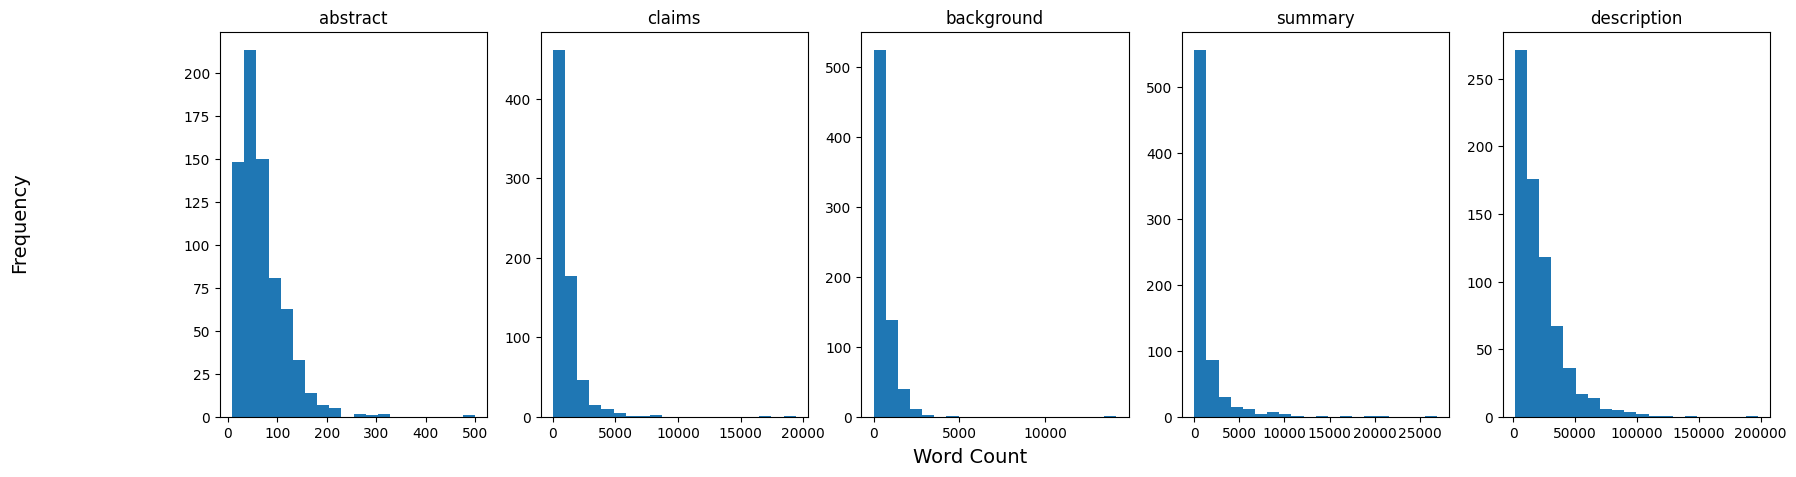

In [ ]:
plot_sections = ['abstract', 'claims', 'background', 'summary', 'description']
num_subplots = len(plot_sections)
fig, axes = plt.subplots(1, num_subplots, figsize = (20,5))
for i in range(num_subplots):
  section = plot_sections[i]
  section_length = [len(train_set[section][i].split()) for i in range(len(train_set[section]))]
  axes[i].hist(section_length, bins = 20)
  axes[i].set_title(section)
fig.supylabel('Frequency', fontsize=14)
fig.supxlabel('Word Count', fontsize=14)

#check the average length of every section
for section in ['abstract', 'claims', 'background', 'summary', 'description']:
    section_length = [len(train_set[section][i].split()) for i in range(len(train_set[section]))]
    # Calculate the average length
    average_length = sum(section_length) / len(section_length)
    print(f'Average {section} length: {average_length: .0f}')

In [ ]:
abstract_length = [len(train_set['abstract'][i].split()) for i in range(len(train_set['abstract']))]
claims_length = [len(train_set['claims'][i].split()) for i in range(len(train_set['claims']))]
background_length = [len(train_set['background'][i].split()) for i in range(len(train_set['background']))]
summary_length = [len(train_set['summary'][i].split()) for i in range(len(train_set['summary']))]
description_length = [len(train_set['description'][i].split()) for i in range(len(train_set['description']))]

In [ ]:
section_lengths = pd.DataFrame({'abstract': abstract_length, 'claims': claims_length, 'background': background_length, 'summary': summary_length, 'description': description_length})

In [ ]:
section_lengths['claims'].value_counts()

723     4
318     4
304     3
1173    3
710     3
       ..
1322    1
1487    1
877     1
665     1
784     1
Name: claims, Length: 601, dtype: int64

##Prepare Data for Summmarization

We only want to try to summarize the abstracts of HUPD dataset by feeding the model the 'claims', 'background', 'summary', and 'description' sections. Given the token limit for model inputs (1024), we will try a few different sections as input for the model to summarize and see which most closely resembles the abstract:

1.   Claims
2.   Background
3.   Summary
4.   Description


In [ ]:
#It seems a number of the patents might have zero input for any one section.
#We will remove patents with no abstract to compare to for all tests.
#Also per summarization test, we will remove patents with no words in the section we want to summarize.
# train_set = train_set.filter(lambda obs, idx: len(train_set['abstract'][idx].split()) != 0, with_indices = True)
# claims_train_set = train_set.filter(lambda obs, idx: len(train_set['claims'][idx].split()) != 0, with_indices = True)
# background_train_set = train_set.filter(lambda obs, idx: len(train_set['background'][idx].split()) != 0, with_indices = True)
# summary_train_set = train_set.filter(lambda obs, idx: len(train_set['summary'][idx].split()) != 0, with_indices = True)
# description_train_set = train_set.filter(lambda obs, idx: len(train_set['description'][idx].split()) != 0, with_indices = True)

Filter:   0%|          | 0/720 [00:00<?, ? examples/s]

Filter:   0%|          | 0/720 [00:00<?, ? examples/s]

Filter:   0%|          | 0/720 [00:00<?, ? examples/s]

Filter:   0%|          | 0/720 [00:00<?, ? examples/s]

Filter:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set a random set of samples to screen throughout summarization
num_examples = 10
random_indices = np.random.choice(len(train_set), num_examples, replace=False)
print(random_indices)

[515 175 380 364 552 238 558   6 692 504]


In [ ]:
#so that we look at the same ones every time.
random_indices = [515, 175, 380, 364, 552, 238, 558, 6, 692, 504]

Observations:

1. The length of patents may cause difficulty in training the model and model accuracy. Combined, the length of the inputs can range into the hundreds of thousands of words.
2. There are  observations with missing data




In [ ]:
#specify base model
model_name = "google/pegasus-large"

#specify compute device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

#specify tokenizer
tokenizer = PegasusTokenizer.from_pretrained(model_name)

#instantiate model
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
#create a function to tokenize the data
def tokenize_input(input,column_name):
    tokenized = tokenizer(input[column_name], truncation=True, padding='max_length', return_tensors="pt") #.to(device)
    tokenized['input_ids'] = tokenized['input_ids'].squeeze()
    tokenized['attention_mask'] = tokenized['attention_mask'].squeeze()
    return tokenized

### Section to Summarize: Claims

In [ ]:
train_set

Dataset({
    features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
    num_rows: 720
})

In [ ]:
# Tokenize training set
tokenized_input = train_set.map(lambda obs: tokenize_input(obs,'claims'))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set format to Torch
tokenized_input.set_format(type='torch', columns=['input_ids', 'attention_mask']) #device = device to load the torch formatted tensors to your GPU.

#set up DataLoader
batch_size = 5 #note that the standard batch size for the DataLoader is 200
train_dataloader = DataLoader(tokenized_input, batch_size = batch_size) #num_workers = 4 << increase if you need higher speed.


In [ ]:
summarized_texts = []
for batch in iter(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 100
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_input['abstract']
claims_results = rouge.compute(predictions=predictions,
                        references=references)
print(claims_results)

{'rouge1': 0.2809411864427584, 'rouge2': 0.14225844703997811, 'rougeL': 0.2225854392451727, 'rougeLsum': 0.22273945117239713}


In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [train_set['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,"<pad>A method for preparing a phase change material comprising: feeding naturally occurring fatty acids and esters to a reactor containing a liquid phase, a gas phase, and a catalyst comprising nickel, molybdenum, cobalt, tungsten, or a combination of any two or more thereof; at least partially hydrogenating/hydrogenolyzing the naturally occurring fatty acids and esters in the reactor; controlling an intracatalyst temperature gradient within the reactor to reduce thermal decarboxylation relative to oxygen hydrogenolysis; and withdrawing a</s>","Paraffin compositions including mainly even carbon number paraffins, and a method for manufacturing the same, is disclosed herein. In one embodiment, the method involves contacting naturally occurring fatty acid/glycerides with hydrogen in a slurry bubble column reactor containing bimetallic catalysts with equivalent particle diameters from about 10 to about 400 micron. The even carbon number compositions are particularly useful as phase change material."
1,"<pad>at the illuminance at a first reaction stage, and continuing to feed the chlorine at a remaining reaction stage at a higher reaction temperature, under a higher illuminance, or both, than the first reaction stage, until the reaction is complete and trichloromethyl-substituted benzene is prepared, wherein X is a chlorine, bromine, or fluorine; a is 0, 1, 2, 3, 4, or 5; b is 1, 2, 3,</s>","The present application relates to a method for photochlorination, and specifically to photochlorination by a photochemical reaction of an aromatic compound with gaseous chlorine so as to prepare a trichloromethyl-substituted benzene, and to a method using bis-(trichloromethyl)-benzene as the trichloromethyl-substituted benzene to prepare by further reaction bis-(chloroformyl)-benzene. Through the control of temperature, illuminance and consumption of gaseous chlorine, the method of this application can greatly improve the purity of trichloromethyl-substituted benzene and further prepare polymer-grade bis-(chloroformyl)-benzene with low cost. The present application also relates to a method for purifying trichloromethyl-substituted benzene, and specifically to a method for purifying trichloromethyl-substituted benzene via molecular distillation. The present application further relates to a photochlorination reactor for use in photochlorination reactions (such as those of the present application)."
2,<pad>The isolated polynucleotide of claim 6 wherein the isolated polynucleotide comprises a nucleotide sequence that encodes the amino acid sequence of SEQ ID NO:58.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>,Disclosed herein are a monoclonal antibody that specifically binds to human CD133 and single-chain variable fragments thereof. Also disclosed herein is a hybridoma that produces the monoclonal antibody that specifically binds to human CD133.
3,"<pad>A purified polypeptide according to claim 1, wherein the Flt4 amino acid sequence is selected from the group consisting of SEQ ID NO: 2 and SEQ ID NO: 4. A purified polypeptide according to claim 1, wherein the fragment comprises Flt4 amino acid sequence capable of generating an immune response specific to Flt4. A purified polypeptide according to claim 1, wherein the fragment comprises Flt4 amino acid sequence capable of generating an immune response that produces antibodies which bind to Flt4 and fail</s>","The present invention provide purified Flt4 receptor tyrosine kinase polypeptides and fragments thereof, polynucleotides encoding such polypeptides, antibodies that specifically bind such polypeptides, and uses therefor."
4,"<pad>A heteromultimer comprising: a first po

In [ ]:
torch.cuda.empty_cache()

### Section to Summarize: Background

In [ ]:
# Tokenize training set
tokenized_input = train_set.map(lambda obs: tokenize_input(obs,'background'))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set format to Torch
tokenized_input.set_format(type='torch', columns=['input_ids', 'attention_mask']) #device = device to load the torch formatted tensors to your GPU.

#set up DataLoader
batch_size = 5 #note that the standard batch size for the DataLoader is 200
train_dataloader = DataLoader(tokenized_input, batch_size = batch_size) #num_workers = 4 << increase if you need higher speed.


In [ ]:
summarized_texts = []
for batch in iter(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 100
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_input['abstract']
background_results = rouge.compute(predictions=predictions,
                        references=references)
print(background_results)

{'rouge1': 0.16845923560444448, 'rouge2': 0.04136334813667219, 'rougeL': 0.11514149381381819, 'rougeLsum': 0.11514688389998773}


In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [train_set['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,<pad>These factors make the latent heat for even carbon number 14 n-hexadecane (carbon number 18) and even carbon number 20 n-hexadecane (carbon number 18) more expensive than the latent heat for even carbon number 14 n-hexadecane (carbon number 18) n-hexadecane (carbon number 18) n-hexadecane (carbon number 18) n-hexadecane (carbon number 18) n-hexadecane (carbon number 18) n</s>,"Paraffin compositions including mainly even carbon number paraffins, and a method for manufacturing the same, is disclosed herein. In one embodiment, the method involves contacting naturally occurring fatty acid/glycerides with hydrogen in a slurry bubble column reactor containing bimetallic catalysts with equivalent particle diameters from about 10 to about 400 micron. The even carbon number compositions are particularly useful as phase change material."
1,"<pad>The present inventors have recognized that the method of preparing trichloromethyl-substituted benzene via photochlorination in the prior art has drawbacks in the following ways. The present inventors have recognized that the method of preparing trichloromethyl-substituted benzene via photochlorination in the prior art has drawbacks in the following ways. 1) The photochlorination reaction is a radical chain reaction and due to the side-reaction, chlorination site and chlorination depth are relatively</s>","The present application relates to a method for photochlorination, and specifically to photochlorination by a photochemical reaction of an aromatic compound with gaseous chlorine so as to prepare a trichloromethyl-substituted benzene, and to a method using bis-(trichloromethyl)-benzene as the trichloromethyl-substituted benzene to prepare by further reaction bis-(chloroformyl)-benzene. Through the control of temperature, illuminance and consumption of gaseous chlorine, the method of this application can greatly improve the purity of trichloromethyl-substituted benzene and further prepare polymer-grade bis-(chloroformyl)-benzene with low cost. The present application also relates to a method for purifying trichloromethyl-substituted benzene, and specifically to a method for purifying trichloromethyl-substituted benzene via molecular distillation. The present application further relates to a photochlorination reactor for use in photochlorination reactions (such as those of the present application)."
2,"<pad>CD133 is an established marker for cancer stem cells Human CD133 is a cell surface glycoprotein that has been used as a marker of hematopoietic stem cells, neural stem cells, and for enrichment of a tumor initiating cell population in many cancers including colon carcinoma and glioblastoma (Kemper et al.; Weigmann et al., 1997; Yin et al., 1997). First, the most widely used anti-CD133 monoclonal antibodies recognize what was initially thought to be poorly-defined</s>",Disclosed herein are a monoclonal antibody that specifically binds to human CD133 and single-chain variable fragments thereof. Also disclosed herein is a hybridoma that produces the monoclonal antibody that specifically binds to human CD133.
3,"<pad>Several tyrosine kinase genes encode transmembrane receptors for polypeptide growth factors and hormones, such as epidermal growth factor (EGF), insulin, insulin-like growth factor-I (IGF-I), platelet derived growth factors (PDGF-A and -B) and fibroblast growth factors (FGFs) [Heldin et al., Cell Regulation, 1: 555-566 (1990); Ullrich et al., Cell, 61: 243-54 (1990)]. The receptors of several hematopoietic</s>","The present invention provide purified Flt4 receptor tyrosine kinase polypeptides and fragments thereof, polynucleotides encoding such polypeptides, antibodies that specifically bind such polypeptides, and uses therefor."
4,<pad><unk>SOH> FIELD OF INVENTION <unk>EOH>The field of the invention is the rational design of a scaffold for custom development of biotherapeutics.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
torch.cuda.empty_cache()

### Section to Summarize: Summary

In [ ]:
# Tokenize training set
tokenized_input = train_set.map(lambda obs: tokenize_input(obs,'summary'))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set format to Torch
tokenized_input.set_format(type='torch', columns=['input_ids', 'attention_mask']) #device = device to load the torch formatted tensors to your GPU.

#set up DataLoader
batch_size = 5 #note that the standard batch size for the DataLoader is 200
train_dataloader = DataLoader(tokenized_input, batch_size = batch_size) #num_workers = 4 << increase if you need higher speed.


In [ ]:
summarized_texts = []
for batch in iter(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 100
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_input['abstract']
summary_results = rouge.compute(predictions=predictions,
                        references=references)
print(summary_results)

{'rouge1': 0.21027743932023846, 'rouge2': 0.09884942327281468, 'rougeL': 0.1599036510289606, 'rougeLsum': 0.15951411386059022}


In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [train_set['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,<pad>2 is a schematic diagram of an embodiment of an operation of a series-reactor process in accordance with the present invention. 3 is a schematic diagram of an alternative embodiment of an operation of a series-reactor process in accordance with the present invention.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>,"Paraffin compositions including mainly even carbon number paraffins, and a method for manufacturing the same, is disclosed herein. In one embodiment, the method involves contacting naturally occurring fatty acid/glycerides with hydrogen in a slurry bubble column reactor containing bimetallic catalysts with equivalent particle diameters from about 10 to about 400 micron. The even carbon number compositions are particularly useful as phase change material."
1,"<pad>In addition, the present invention provides the preparation of bis-(trichloromethyl)-benzene with a high purity, which is useful for producing aramid fiber, where a high purity of bis-(trichloromethyl)-benzene in trichloromethyl-substituted benzene is used as a raw material to react with 99.5% phthalic acid, and then bis-(chloroformyl)-benzene with a high purity is obtained following purification such as rectification or molecular</s>","The present application relates to a method for photochlorination, and specifically to photochlorination by a photochemical reaction of an aromatic compound with gaseous chlorine so as to prepare a trichloromethyl-substituted benzene, and to a method using bis-(trichloromethyl)-benzene as the trichloromethyl-substituted benzene to prepare by further reaction bis-(chloroformyl)-benzene. Through the control of temperature, illuminance and consumption of gaseous chlorine, the method of this application can greatly improve the purity of trichloromethyl-substituted benzene and further prepare polymer-grade bis-(chloroformyl)-benzene with low cost. The present application also relates to a method for purifying trichloromethyl-substituted benzene, and specifically to a method for purifying trichloromethyl-substituted benzene via molecular distillation. The present application further relates to a photochlorination reactor for use in photochlorination reactions (such as those of the present application)."
2,"<pad>In some embodiments, the scFv comprises the amino acid sequence of SEQ ID NO:47, SEQ ID NO:48, SEQ ID NO:49, SEQ ID NO:50, SEQ ID NO:51, SEQ ID NO:52, SEQ ID NO:53, SEQ ID NO:54, or SEQ ID NO:55. In another aspect, the invention provides an isolated polynucleotide comprising a nucleotide sequence that encodes the</s>",Disclosed herein are a monoclonal antibody that specifically binds to human CD133 and single-chain variable fragments thereof. Also disclosed herein is a hybridoma that produces the monoclonal antibody that specifically binds to human CD133.
3,"<pad><unk>SOH> SUMMARY OF THE INVENTION <unk>EOH>The present invention addresses a gene for a novel receptor tyrosine kinase located on chromosome 5, identified as an unknown tyrosine kinase-homologous PCR-cDNA fragment from human leukemia cells [Aprelikova et al., Cancer Res., 52: 746-748 (1992)]. In 12.5 day post-coital embryos the Flt4 signal is observed on developing venous and presumptive lymphatic endothelia,</s>","The present invention provide purified Flt4 receptor tyrosine kinase polypeptides and fragments thereof, polynucleotides encoding such polypeptides, antibodies that specifically bind such polypeptides, and uses therefor."
4,"<pad>In another aspect of the invention there is provided a heteromultimer comprising: a first polypeptide construct that comprises (i) a first transporter polypeptide; and a second polypeptide construct that comprises (ii) a second transporter polypeptide; wherein each of said first and second transporter poly

In [ ]:
torch.cuda.empty_cache()

### Section to Summarize: Description

In [ ]:
# Tokenize training set
tokenized_input = train_set.map(lambda obs: tokenize_input(obs,'description'))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set format to Torch
tokenized_input.set_format(type='torch', columns=['input_ids', 'attention_mask']) #device = device to load the torch formatted tensors to your GPU.

#set up DataLoader
batch_size = 5 #note that the standard batch size for the DataLoader is 200
train_dataloader = DataLoader(tokenized_input, batch_size = batch_size) #num_workers = 4 << increase if you need higher speed.


In [ ]:
summarized_texts = []
for batch in iter(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 100
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_input['abstract']
description_results = rouge.compute(predictions=predictions,
                        references=references)
print(description_results)

{'rouge1': 0.31159198893087137, 'rouge2': 0.1565806787896383, 'rougeL': 0.24118594440897367, 'rougeLsum': 0.24121895482964434}


In [ ]:
# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [train_set['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,"<pad>Field of the Invention The present invention relates to producing specialty materials and chemical intermediates from bio-renewable feedstocks such as animal fats, plant oils, algal oils, bio-derived greases, and tall oil fatty acid (hereafter referred to as biological feedstocks, or alternatively, fatty acids and/or glycerides depending upon the composition of the feedstock). Specifically, the present invention relates to predominantly even carbon number 231 paraffin compositions in the C12-C24 range, and the catalytic</s>","Paraffin compositions including mainly even carbon number paraffins, and a method for manufacturing the same, is disclosed herein. In one embodiment, the method involves contacting naturally occurring fatty acid/glycerides with hydrogen in a slurry bubble column reactor containing bimetallic catalysts with equivalent particle diameters from about 10 to about 400 micron. The even carbon number compositions are particularly useful as phase change material."
1,"<pad>TECHNICAL FIELD The present application relates to a method for photochlorination, and specifically to photochlorination by a photochemical reaction of an aromatic compound with gaseous chlorine so as to prepare a trichloromethyl-substituted benzene, and to a method using bis-(trichloromethyl)-benzene as the trichloromethyl-substituted benzene to prepare by further reaction bis-(chloroformyl)-benzene. Through the control of temperature, illum</s>","The present application relates to a method for photochlorination, and specifically to photochlorination by a photochemical reaction of an aromatic compound with gaseous chlorine so as to prepare a trichloromethyl-substituted benzene, and to a method using bis-(trichloromethyl)-benzene as the trichloromethyl-substituted benzene to prepare by further reaction bis-(chloroformyl)-benzene. Through the control of temperature, illuminance and consumption of gaseous chlorine, the method of this application can greatly improve the purity of trichloromethyl-substituted benzene and further prepare polymer-grade bis-(chloroformyl)-benzene with low cost. The present application also relates to a method for purifying trichloromethyl-substituted benzene, and specifically to a method for purifying trichloromethyl-substituted benzene via molecular distillation. The present application further relates to a photochlorination reactor for use in photochlorination reactions (such as those of the present application)."
2,"<pad>The tumor cell populations include a relatively small cohort of less differentiated, self-renewing, tumor initiating stem cells and a relatively larger cohort of more differentiated tumor cells. CD133 is an established marker for cancer stem cells Human CD133 is a cell surface glycoprotein that has been used as a marker of hematopoietic stem cells, neural stem cells, and for enrichment of a tumor initiating cell population in many cancers including colon carcinoma and glioblastoma (Kemper et al.; Weigmann et</s>",Disclosed herein are a monoclonal antibody that specifically binds to human CD133 and single-chain variable fragments thereof. Also disclosed herein is a hybridoma that produces the monoclonal antibody that specifically binds to human CD133.
3,"<pad>More specifically, the present invention is directed to Flt4, a receptor tyrosine kinase; to extracellular sequences encoding Flt4; to methods for the generation of DNAs encoding Flt4 and their gene products; to nucleic acid probes which specifically recognize (hybridize to) nucleic acids encoding such receptors; to antibodies that specifically recognize such receptors; and to methods of using such probes and antibodies and other Flt4 binding compounds, e.g., for identifying lymphatic vessels and high</s>","The present invention provide purified Flt4 receptor tyrosine kinase polypeptides and fragments thereof, polynucleotides encoding such polypeptides, antibodies that specifically bind such polypeptides, and us

In [ ]:
#The first example in the dataset is almost a perfect copy of the abstract, indicating the model cheated on this example..

# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[0]]
sampled_abstracts = [train_set['abstract'][0]]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,"<pad>FIELD OF THE INVENTION The present invention relates to an antibody construct comprising a first human binding domain specific for the extracellular part of the influenza envelope protein M2 and a second domain specific for CD3. Moreover, the invention provides a nucleic acid molecule encoding the antibody construct, a vector comprising said nucleic acid molecule and a host cell transformed or transfected with said nucleic acid molecule or vector. Furthermore, the invention provides a process for the production of the antibody construct of the</s>","The present invention relates to an antibody construct comprising a first human binding domain specific for the extracellular part of the influenza envelope protein M2 (M2e) and a second domain specific for CD3. Moreover, the invention provides a nucleic acid molecule encoding the antibody construct, a vector comprising said nucleic acid molecule and a host cell transformed or transfected with said nucleic acid molecule or vector. Furthermore, the invention provides a process for the production of the antibody construct of the invention, a pharmaceutical composition comprising said antibody construct, a medical use/method of treatment relating to said antibody construct, and a kit comprising said antibody construct."


In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(f'Claims Results: {claims_results}')
print(f'Summary Results: {summary_results}')
print(f'Background Results: {background_results}')
print(f'Description Results: {description_results}')

Claims Results: {'rouge1': 0.2809411864427584, 'rouge2': 0.14225844703997811, 'rougeL': 0.2225854392451727, 'rougeLsum': 0.22273945117239713}
Summary Results: {'rouge1': 0.21027743932023846, 'rouge2': 0.09884942327281468, 'rougeL': 0.1599036510289606, 'rougeLsum': 0.15951411386059022}
Background Results: {'rouge1': 0.16845923560444448, 'rouge2': 0.04136334813667219, 'rougeL': 0.11514149381381819, 'rougeLsum': 0.11514688389998773}
Description Results: {'rouge1': 0.31159198893087137, 'rouge2': 0.1565806787896383, 'rougeL': 0.24118594440897367, 'rougeLsum': 0.24121895482964434}


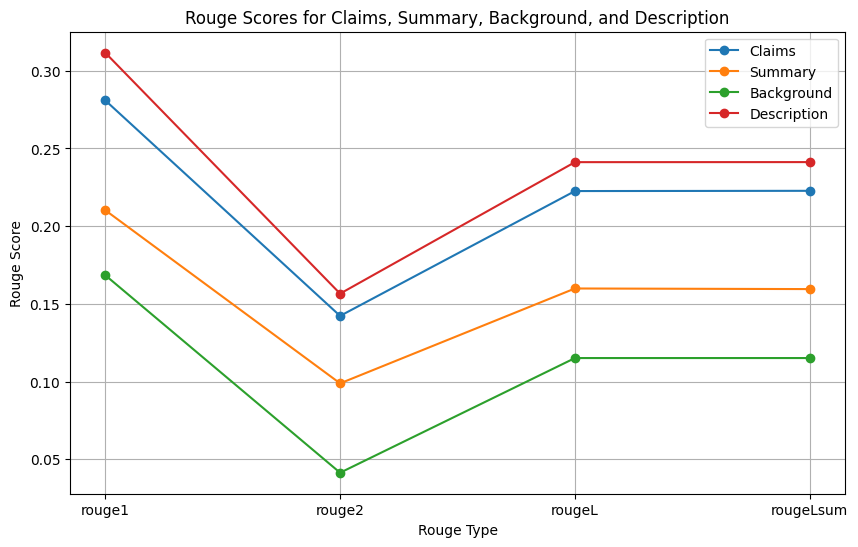

In [ ]:
# Extract Rouge scores
rouge_types = list(claims_results.keys())
claims_scores = [claims_results[rouge_type] for rouge_type in rouge_types]
summary_scores = [summary_results[rouge_type] for rouge_type in rouge_types]
background_scores = [background_results[rouge_type] for rouge_type in rouge_types]
description_scores = [description_results[rouge_type] for rouge_type in rouge_types]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rouge_types, claims_scores, marker='o', label='Claims')
plt.plot(rouge_types, summary_scores, marker='o', label='Summary')
plt.plot(rouge_types, background_scores, marker='o', label='Background')
plt.plot(rouge_types, description_scores, marker='o', label='Description')

# Adding labels and title
plt.xlabel('Rouge Type')
plt.ylabel('Rouge Score')
plt.title('Rouge Scores for Claims, Summary, Background, and Description')
plt.legend()
plt.grid(True)
plt.show()

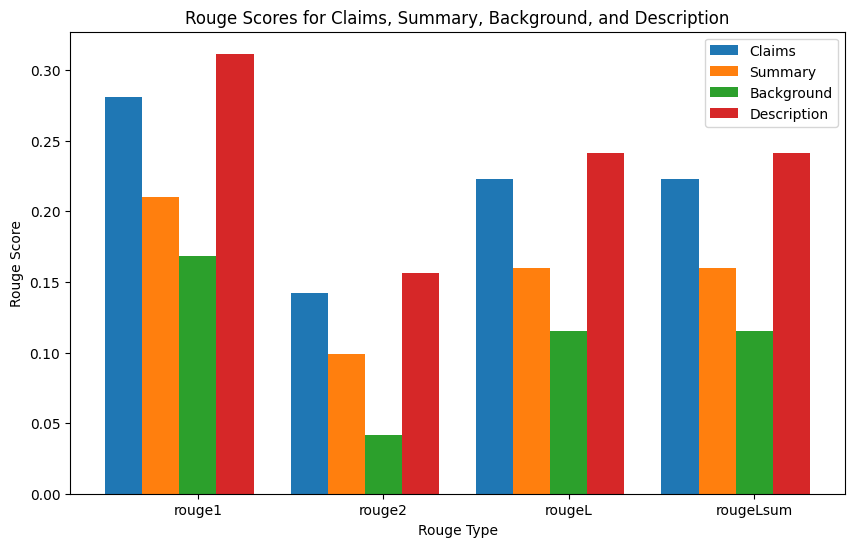

In [ ]:

# Extract Rouge scores
rouge_types = list(claims_results.keys())
claims_scores = [claims_results[rouge_type] for rouge_type in rouge_types]
summary_scores = [summary_results[rouge_type] for rouge_type in rouge_types]
background_scores = [background_results[rouge_type] for rouge_type in rouge_types]
description_scores = [description_results[rouge_type] for rouge_type in rouge_types]

# Plotting as bar chart
bar_width = 0.2
index = np.arange(len(rouge_types))

plt.figure(figsize=(10, 6))
plt.bar(index - bar_width, claims_scores, bar_width, label='Claims')
plt.bar(index, summary_scores, bar_width, label='Summary')
plt.bar(index + bar_width, background_scores, bar_width, label='Background')
plt.bar(index + 2 * bar_width, description_scores, bar_width, label='Description')

# Adding labels and title
plt.xlabel('Rouge Type')
plt.ylabel('Rouge Score')
plt.title('Rouge Scores for Claims, Summary, Background, and Description')
plt.xticks(index + bar_width, rouge_types)
plt.legend()
plt.show()

## Observations from First Summarization Attempt:


##Scores:


1. ROUGE scores are relatively low.
3. Some of the summaries (for example, the first obs in the dataset) are perfect copies of the abstracts. Since we are using Pegasus-large which was fine-tuned on the BigPatent database, it is possible that the model memorized the abstracts from the BigPatent dataset, and we are seeing the results of overlap in the datasets.
4. The model gave up when trying to recall an especially long chemical name, and simply ended the summary halfway through the name.
5. May struggle to discern relationships between chemical compounds.
6. In the 'claims', 'background', and 'summary' sections, prettymuch anything the model didn't copy outright is trash.
